In [1]:
from pathlib import Path
from typing import Callable, Optional
from dataclasses import dataclass

from opt_sim_dataset import ConsecutiveOutputsDataset 

import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch.utils.data import DataLoader, random_split

from tqdm.notebook import tqdm

In [9]:
def get_est_svd(X, Y):
    """
    X -- torch tensor with shape [n_samples, dim]
    Y -- torch tensor with shape [n_samples, dim]

    Approximates Y matrix with linear transformation Y = XA
    """
    U, S, Vh = torch.linalg.svd(X, full_matrices=False)
    A_estimation = Vh.T * (1 / S)[None, ...] @ U.T @ Y # Y=XA
    Y_est =  X @ A_estimation
    return Y_est

def compute_linearity_score(x, y):
    """
    x -- torch tensor with shape [n_samples, dim]
    y -- torch tensor with shape [n_samples, dim]
    """
    with torch.no_grad(): 
        X = x - x.mean(dim=0, keepdim=True)
        Y = y - y.mean(dim=0, keepdim=True)
    
        X = X / X.norm()
        Y = Y / Y.norm()

        Y_estimation = get_est_svd(X, Y)
    
        y_error = (Y_estimation - Y).square().sum()
        sim = float(1 - y_error)
    return sim

In [20]:
tmp_x = torch.randn((1000, 2048))
A = torch.randn((2048, 2048))
tmp_y = tmp_x @ A
compute_linearity_score(tmp_x, tmp_y)  

0.999904215335846

In [33]:
tmp_x = torch.randn((10_000, 2048))
tmp_y = torch.cos(tmp_x + torch.pi) + torch.tanh(tmp_x) 
compute_linearity_score(tmp_x, tmp_y)  

0.6263377070426941

In [29]:
k_samples = 10_000
tmp_x = torch.randn((k_samples, 2048))
tmp_y = torch.randn((k_samples, 2048))
compute_linearity_score(tmp_x, tmp_y)

0.20304471254348755

In [10]:
data = ConsecutiveOutputsDataset(Path('./data'), 18, 26, 0) 

In [11]:
block_embeddings = [[] for _ in range(data.num_layers)]
for x, v1, v2, blocks in data:
    block = blocks[0]
    block_embeddings[block].append(x)
    if block == data.num_layers - 2:
        block_embeddings[block + 1].append(v1)

In [12]:
block_embeddings = [torch.cat(x).reshape(-1, 2048) for x in block_embeddings]

In [15]:
block_embeddings[0].shape

torch.Size([1310, 2048])

In [35]:
k = 1
for idx in range(data.num_layers - k):
    print(idx, compute_linearity_score(block_embeddings[idx], block_embeddings[idx + k]))

0 -25754088.0
1 -993966.75
2 -23905.2734375
3 -49128.734375
4 -112728.171875
5 -50275.7890625
6 -22190228.0
7 -32703.24609375
8 -186954336.0
9 -33592.859375
10 -2692048.25
11 -35576820.0
12 -112863.5234375
13 -292085.625
14 -22233.93359375
15 -19141.375
16 -21016.76171875


In [36]:
def get_linearity_dist(block1, block2, batch_size=2):
    n_samples = block1.size(0)
    assert n_samples == block2.size(0)
    linearities = torch.zeros(n_samples // batch_size)
    for idx in range(0, n_samples // batch_size):
        indices = torch.arange(idx * batch_size, (idx + 1) * batch_size)
        batch1 = block1[indices].view(batch_size, -1)
        batch2 = block2[indices].view(batch_size, -1)
        linearities[idx] = compute_linearity_score(batch1, batch2)
    
    return linearities

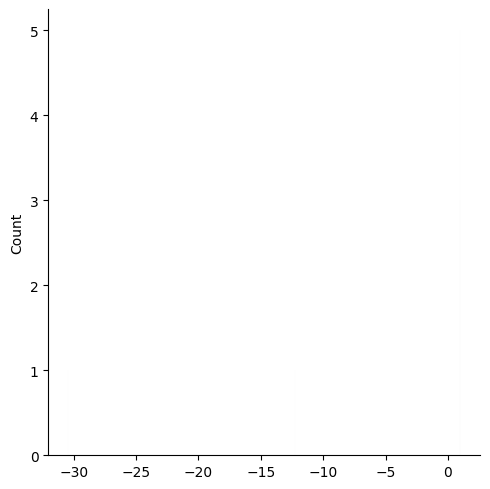

In [37]:
import seaborn as sns

sns.displot(get_linearity_dist(block_embeddings[11], block_embeddings[12], batch_size=128))

In [38]:
class SimpleAutoEncoder(nn.Module):
    def __init__(self, embed_dim: int, hidden_size: int):
        super(SimpleAutoEncoder, self).__init__()

        self.fc1 = nn.Linear(embed_dim, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(embed_dim, hidden_size)
    
    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

In [42]:
N = len(data)
train_len = int(N * 0.7)
train_data, test_data = random_split(data, lengths=[train_len, N - train_len])
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)
tgt_block = 7

In [47]:
criterion = nn.MSELoss()
# model = SimpleAutoEncoder(768, 768).to('cuda')
model = nn.Linear(2048, 2048).to('cuda')
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
for epoch in range(7):
    epoch_loss = 0
    model.train()
    for x, v1, v2, blocks in train_loader:
        x_blocks = blocks[:, 0]
        indices = x_blocks == tgt_block 
        if indices.sum() == 0:
            continue
        
        optimizer.zero_grad()
        outputs = model(x[indices])
        loss = criterion(outputs , v1[indices])
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    
    test_loss = 0
    model.eval()
    for x, v1, v2, blocks in test_loader:
        x_blocks = blocks[:, 0]
        indices = x_blocks == tgt_block
        if indices.sum() == 0:
            continue
    
        outputs = model(x[indices])
        loss = criterion(outputs, v1[indices])
        test_loss += loss.item()

    print(f'{epoch=}, Train loss: {epoch_loss / len(train_data):.4e}, Test loss {test_loss / len(test_data):.4e}')

epoch=0, Train loss: 4.4106e-01, Test loss 3.4074e-01
epoch=1, Train loss: 4.2979e-01, Test loss 1.1486e+00
epoch=2, Train loss: 3.9888e-01, Test loss 2.3597e-01
epoch=3, Train loss: 2.3728e-01, Test loss 2.4442e-01


KeyboardInterrupt: 

In [48]:
for idx in range(len(block_embeddings)):
    print(idx, block_embeddings[idx].norm(dim=-1).mean()) 

0 tensor(225.2736, device='cuda:0')
1 tensor(175.2841, device='cuda:0')
2 tensor(168.0583, device='cuda:0')
3 tensor(161.6372, device='cuda:0')
4 tensor(159.1138, device='cuda:0')
5 tensor(159.2699, device='cuda:0')
6 tensor(158.0076, device='cuda:0')
7 tensor(164.0233, device='cuda:0')
8 tensor(172.5543, device='cuda:0')
9 tensor(178.2345, device='cuda:0')
10 tensor(185.1689, device='cuda:0')
11 tensor(193.1785, device='cuda:0')
12 tensor(195.2941, device='cuda:0')
13 tensor(221.1150, device='cuda:0')
14 tensor(254.6856, device='cuda:0')
15 tensor(318.5261, device='cuda:0')
16 tensor(398.3754, device='cuda:0')
17 tensor(547.7927, device='cuda:0')


In [51]:
for idx in range(len(block_embeddings) - 1):
    print(idx, F.cosine_similarity(block_embeddings[idx], block_embeddings[idx + 1], dim=-1).mean())

0 tensor(0.2451, device='cuda:0')
1 tensor(0.9698, device='cuda:0')
2 tensor(0.9758, device='cuda:0')
3 tensor(0.9795, device='cuda:0')
4 tensor(0.9859, device='cuda:0')
5 tensor(0.9867, device='cuda:0')
6 tensor(0.9873, device='cuda:0')
7 tensor(0.9912, device='cuda:0')
8 tensor(0.9924, device='cuda:0')
9 tensor(0.9913, device='cuda:0')
10 tensor(0.9904, device='cuda:0')
11 tensor(0.9826, device='cuda:0')
12 tensor(0.9817, device='cuda:0')
13 tensor(0.9664, device='cuda:0')
14 tensor(0.9456, device='cuda:0')
15 tensor(0.9530, device='cuda:0')
16 tensor(0.8322, device='cuda:0')
